


<span style="font-size:30px;"> Gen AI Intensive Course Capstone Proyect.  </span>

<span style="font-size:25px;">  Re-ranking search using Emebeddings </span>


**In this proyect I am going to Re rank search in google search using it as a tool, thanks to gemini tools we are going to search for response a querys for especific topic we are interested, in this example the question to our gemini model is "tell me about how the life begins" but we can give them to our model different questions to re rank the result and find the best response using embeddings.**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.5 MB/s eta 0:00:00


In [4]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [5]:
#Setting our credentials
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [6]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [7]:
#setting the libraries we are gonna use
from IPython.display import display, Image, Markdown

import numpy as np

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [9]:
#importing the libraries we need

import json
import textwrap
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
    


**Writing the instruccions to use the google search tool to finds our querys **


In [13]:

instructions = """You have access to google search API which you will be using
to answer a user's query. Your job is to generate a list of search queries which
might answer a user's question. Be creative by using various key-phrases from
the user's query. To generate variety of queries, ask questions which are
related to  the user's query that might help to find the answer. The more
queries you generate the better are the odds of you finding the correct answer.
Here is an example:

user: Tell me about Cricket World cup 2023 winners.

function_call: wikipedia_search(['What is the name of the team that
won the Cricket World Cup 2023?', 'Who was the captain of the Cricket World Cup
2023 winning team?', 'Which country hosted the Cricket World Cup 2023?', 'What
was the venue of the Cricket World Cup 2023 final match?', 'Cricket World cup 2023',
'Who lifted the Cricket World Cup 2023 trophy?'])

The search function will return just a list of article summaries, use these to
answer the  user's question, Limit the list just to 7 to 10  querys, dont use wikipedia search

Here is the user's query: {query}
"""



**Now I Config the model to use the google search tool and setting the temperature to our model give us a varied answer**
**In this step we are gonna set the query to the tipoic we are interested in**


In [14]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.7,
)

chat = client.chats.create(model='gemini-2.0-flash', history=[])
query="tell me about how the life begins"

res = chat.send_message(instructions.format(query=query))
res



GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Here are some Google search queries related to the question "tell me about how the life begins":\n\n1.  "What is the origin of life on Earth?"\n2.  "How does life form from non-living matter?"\n3.  "What are the first building blocks of life?"\n4.  "Theories on the abiogenesis of life"\n5.  "What is the role of RNA in the origin of life?"\n6.  "What were the conditions on early Earth that allowed life to begin?"\n7.  "Miller-Urey experiment: simulating early Earth conditions"\n8. "Stages of development from conception to birth"\n9. "Scientific explanation of fertilization and conception"\n')], role='model'), citation_metadata=None, finish_message=None, token_count=None, avg_logprobs=-0.2777725018953022, finish_reason=<FinishReason.STOP: 'STOP'>, g




**Showing the querys we get**


In [15]:

to_markdown(res.text)

> Here are some Google search queries related to the question "tell me about how the life begins":
> 
> 1.  "What is the origin of life on Earth?"
> 2.  "How does life form from non-living matter?"
> 3.  "What are the first building blocks of life?"
> 4.  "Theories on the abiogenesis of life"
> 5.  "What is the role of RNA in the origin of life?"
> 6.  "What were the conditions on early Earth that allowed life to begin?"
> 7.  "Miller-Urey experiment: simulating early Earth conditions"
> 8. "Stages of development from conception to birth"
> 9. "Scientific explanation of fertilization and conception"



**the next step is to extract the querys in a list**


In [16]:

import re
search_queries = re.findall(r'"([^"]*)"', res.text)

print(search_queries)
len(search_queries)

['tell me about how the life begins', 'What is the origin of life on Earth?', 'How does life form from non-living matter?', 'What are the first building blocks of life?', 'Theories on the abiogenesis of life', 'What is the role of RNA in the origin of life?', 'What were the conditions on early Earth that allowed life to begin?', 'Miller-Urey experiment: simulating early Earth conditions', 'Stages of development from conception to birth', 'Scientific explanation of fertilization and conception']


10



**Now that we have our querys lets search and save the response of each query to re rank the best answer**



In [17]:
summary=[]

short_config = types.GenerateContentConfig(max_output_tokens=200)

for query in search_queries:
     summary.append(client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents=query))



**lets watch an example of one response of the model**


In [18]:

to_markdown(summary[4].text)

> Abiogenesis, the origin of life from non-living matter, is a fascinating and complex field with many competing hypotheses. Here's a breakdown of some prominent theories, their supporting evidence, and challenges:
> 
> **1. The Primordial Soup (Oparin-Haldane Hypothesis):**
> 
> *   **Core Idea:** Life originated in a "primordial soup" of organic molecules formed in Earth's early oceans. Energy from lightning, UV radiation, and volcanic activity drove the formation of these molecules from simple inorganic precursors. These molecules then gradually assembled into more complex structures like proteins and nucleic acids.
> *   **Supporting Evidence:**
>     *   **Miller-Urey Experiment (1953):** Simulated early Earth conditions in a lab and successfully created amino acids (building blocks of proteins) from inorganic gases.
>     *   **Subsequent Experiments:** Similar experiments using slightly different conditions have produced all the standard amino acids, nucleotide bases, and other important biomolecules.

**Emebedding my querys and response data**

In [19]:

search_res = client.models.embed_content(
    model='models/text-embedding-004',
    contents=summary,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))


embedded_query = client.models.embed_content(
    model='models/text-embedding-004',
    contents=search_queries,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))



**now lets calculate  similarity score of two embedding vectors that can be obtained by calculating their inner product.In this case $\mathbf{a}$ is the first embedding vector, and $\mathbf{b}$ the second, this is $\mathbf{a}^T \mathbf{b}$**


In [20]:
a=pd.DataFrame([e.values for e in search_res.embeddings])
b=pd.DataFrame([e.values for e in embedded_query.embeddings])

sim = a @ b.T

**lets print the values**

In [21]:
sim

,0,1,2,3,4,5,6,7,8,9
0,0.700815,0.826114,0.803442,0.762285,0.765955,0.803296,0.775023,0.668129,0.623980,0.629680
1,0.613156,0.811552,0.771517,0.745707,0.761417,0.736909,0.784296,0.639268,0.572043,0.622010
2,0.613914,0.760196,0.782292,0.713469,0.745193,0.725144,0.702113,0.572834,0.592849,0.627664
3,0.568573,0.715882,0.697506,0.825508,0.653114,0.702573,0.714648,0.596637,0.545545,0.515661
4,0.607566,0.785905,0.769421,0.720012,0.804963,0.711639,0.741259,0.730536,0.556210,0.613672
5,0.555931,0.684796,0.648948,0.664411,0.646005,0.846903,0.669310,0.589796,0.531530,0.541269
6,0.579273,0.745148,0.665286,0.656183,0.673235,0.640043,0.821956,0.663743,0.549753,0.568422
7,0.561402,0.713385,0.703263,0.674816,0.658395,0.638277,0.740633,0.836944,0.538787,0.583756
8,0.691537,0.576794,0.656786,0.630686,0.547880,0.554447,0.548215,0.526072,0.828388,0.711648
9,0.645529,0.608339,0.622202,0.605723,0.563092,0.554382,0.584021,0.526535,0.712254,0.794757


**Lets Calculate the max value**

In [22]:
indice_aplanado=np.argmax(sim)
indices_maximo = np.unravel_index(indice_aplanado, sim.shape)
print(indice_aplanado)
print(indices_maximo)

55
(5, 5)


**Visualizing the best response**

In [23]:
print(summary[indices_maximo[0]].text)
print(search_queries[indices_maximo[1]])

RNA is believed to have played a pivotal role in the origin of life, with many scientists advocating for the "RNA world" hypothesis. Here's a breakdown of its proposed roles:

**1. Genetic Information Storage and Transmission:**

*   **Simpler than DNA:** RNA is structurally simpler than DNA, making it potentially easier to synthesize in prebiotic conditions. It uses ribose sugar instead of deoxyribose (DNA) and has uracil (U) instead of thymine (T).
*   **Self-Replication:** RNA has the potential to self-replicate, although this process is not efficient on its own. However, with the right conditions and catalysts (like ribozymes), RNA replication could have allowed for the propagation and evolution of genetic information before DNA.

**2. Catalytic Activity (Ribozymes):**

*   **Enzymatic Function:** Unlike DNA, RNA can fold into complex 3D structures, allowing it to act as an
What is the role of RNA in the origin of life?


**Now we can rank the response of the model according to each query**

In [52]:
sim[1].sort_values(ascending=False)

0    0.826114
1    0.811552
4    0.785905
2    0.760196
6    0.745148
3    0.715882
7    0.713385
5    0.684796
9    0.608339
8    0.576794
Name: 1, dtype: float64

**Finally we can see the results in a headmap and  observe the max a min values of our embeddings**

Text(83.22222222222221, 0.5, 'Querys')

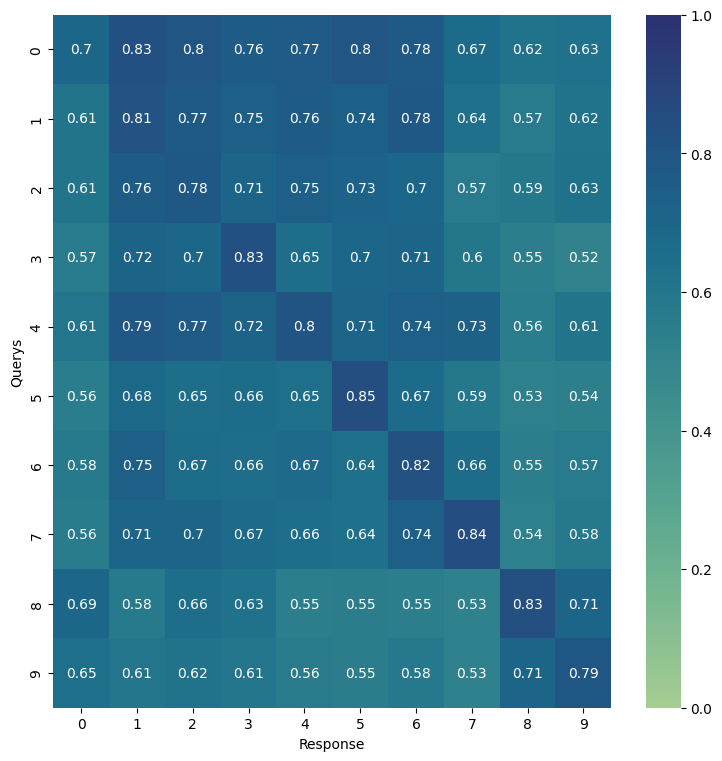

In [55]:
	
#Drwing our results in a headmap with seaborn library

import matplotlib.pyplot as plt # for data visualization
import seaborn as sns


plt.figure(figsize=(9,9))
sns.heatmap(sim, vmin=0, vmax=1, annot=True, cmap="crest")
plt.xlabel("Response") 
plt.ylabel("Querys") 